# Предсказание оттока клиентов

Использован датасет https://www.kaggle.com/blastchar/telco-customer-churn

#### Описание датасета:

Each row represents a customer, each column contains customer’s attributes described on the column Metadata.

The data set includes information about:

- Customers who left within the last month – the column is called Churn
- Services that each customer has signed up for – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies
- Customer account information – how long they’ve been a customer, contract, payment method, paperless billing, monthly charges, and total charges
- Demographic info about customers – gender, age range, and if they have partners and dependents

#### Задача:

создать приложение, которое будет выдавать ответ, склонен ли запрашиваемый покупатель (покупатели) уйти в отток. 

Подразумевается, что можно ввести неправильные данные или незнакомый для предобученной модели категориальный признак, задача по этим данным сделать прогноз. 

Обработка данных происходит только в рамках пайплайна. Отсутствующие/ошибочные данные в количественных признаках заполняются медианой, в категориальных - модой  


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from catboost import CatBoostClassifier
import dill
import warnings
warnings.simplefilter('ignore')

In [2]:
df= pd.read_csv('C:/Users/yana/3/WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.head(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
df['Churn'].value_counts(normalize=True) #дисбалансное распределение, но не самое плохое.
#Увеличение кол-ва миноритарного класса с помощью дубликатов или балансировки весов в модели в итоге негативно 
#сказалось на результате 

No     0.73463
Yes    0.26537
Name: Churn, dtype: float64

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


Подразумевается, что признак "TotalCharges" должен быть количественный, но здесь он категориальный и содержит пустые строки

In [5]:
df.loc[df['TotalCharges']==' ']

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,No
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,No
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,No
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,No
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,No
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,No
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,No
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,No
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,,No


видно, что клиенты с пустым "TotalCharges" - это не ошибка, это новые клиенты (tenure = 0). В данном случае будем заполнять "TotalCharges" нулями. Сделаем копию датасета для обработки признака TotalCharges и дальнейшего изучения данных. Обработку для модели будем делать в пайплайне

In [6]:
copy = df.copy()
copy.loc[copy['TotalCharges']==' ', 'TotalCharges']=0
copy['TotalCharges'] = copy['TotalCharges'].astype('float64')

In [7]:
copy.describe() #SeniorCitizen - категориальный признак, он здесь не очень нужен

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692,2279.734304
std,0.368612,24.559481,30.090047,2266.794470
min,0.000000,0.000000,18.250000,0.000000
25%,0.000000,9.000000,35.500000,398.550000
50%,0.000000,29.000000,70.350000,1394.550000
75%,0.000000,55.000000,89.850000,3786.600000
max,1.000000,72.000000,118.750000,8684.800000


array([[<AxesSubplot:title={'center':'SeniorCitizen'}>,
        <AxesSubplot:title={'center':'tenure'}>],
       [<AxesSubplot:title={'center':'MonthlyCharges'}>,
        <AxesSubplot:title={'center':'TotalCharges'}>]], dtype=object)

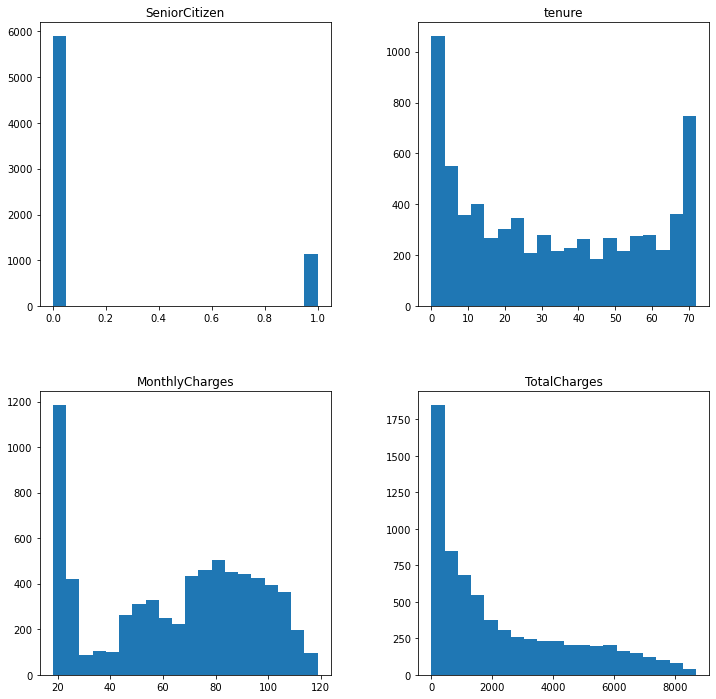

In [8]:
num_features = copy.select_dtypes(exclude=['object'])
num_features.hist(figsize=(12,12), bins=20, grid=False)

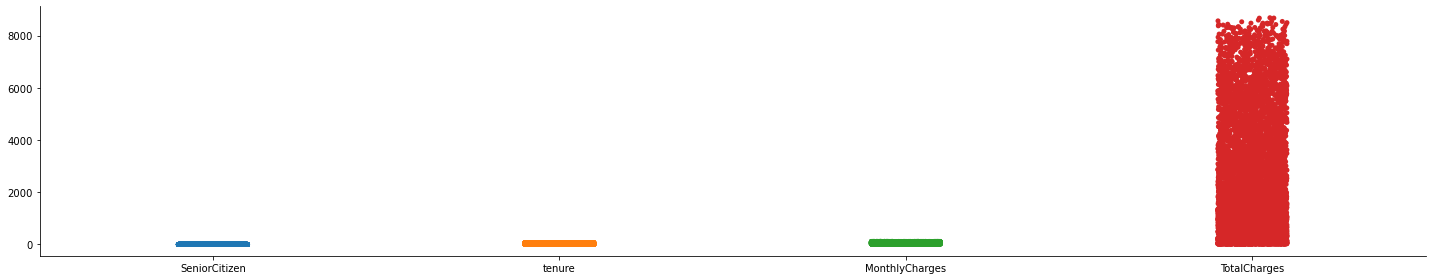

In [9]:
sns.catplot(data = copy, height = 4, aspect = 5)

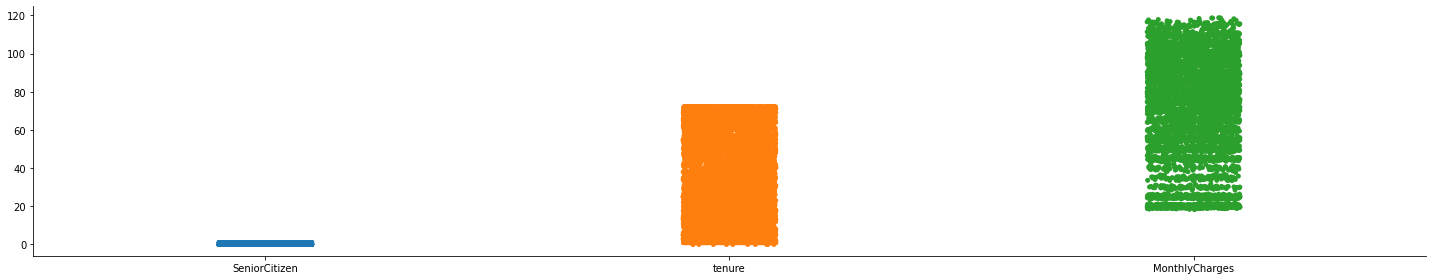

In [10]:
sns.catplot(data = df, height = 4, aspect = 5)

Выбросов не видно, много новых клиентов, у которых charges близки к нулю, распределение по всем признакам не нормальное

In [11]:
for col in df:
    print(col, '-->', np.unique(df[col]))

customerID --> ['0002-ORFBO' '0003-MKNFE' '0004-TLHLJ' ... '9992-UJOEL' '9993-LHIEB'
 '9995-HOTOH']
gender --> ['Female' 'Male']
SeniorCitizen --> [0 1]
Partner --> ['No' 'Yes']
Dependents --> ['No' 'Yes']
tenure --> [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72]
PhoneService --> ['No' 'Yes']
MultipleLines --> ['No' 'No phone service' 'Yes']
InternetService --> ['DSL' 'Fiber optic' 'No']
OnlineSecurity --> ['No' 'No internet service' 'Yes']
OnlineBackup --> ['No' 'No internet service' 'Yes']
DeviceProtection --> ['No' 'No internet service' 'Yes']
TechSupport --> ['No' 'No internet service' 'Yes']
StreamingTV --> ['No' 'No internet service' 'Yes']
StreamingMovies --> ['No' 'No internet service' 'Yes']
Contract --> ['Month-to-month' 'One year' 'Two year']
PaperlessBilling --> ['No' 'Yes']
PaymentMethod --> ['Bank 

In [12]:
df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [13]:
bool_cols = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']
cat_cols = ['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod']
change_col = ['TotalCharges']
num_cols = ['tenure', 'MonthlyCharges']

#### Обработка целевой переменной и разбиение датасета на трейн и тест

In [14]:
df['Churn'] = np.where(df['Churn']=='Yes', 1, 0)
X = df.drop(['Churn'], axis=1)
y = df['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [15]:
#save test
X_test.to_csv("X_test.csv", index=None)
y_test.to_csv("y_test.csv", index=None)
#save train
X_train.to_csv("X_train.csv", index=None)
y_train.to_csv("y_train.csv", index=None)

#### Подготовка пайплайна

In [16]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X, y=None):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]
    
class Bool_col(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.mode = None
        self.unique = None
        
    def fit(self, X, y=None):
        self.mode = X.mode()[0]
        self.unique = np.unique(X)
        return self
    
    def transform(self, X, y=None):
        for el in X:
            if el not in self.unique:
                el = self.mode
        zero = self.unique[0]
        X = np.where(X==zero, 0, 1)
        return X.reshape(len(X), 1)
    
class for_TotCharges(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X[self.key] = np.where(X[self.key]==' ',0, X[self.key])
        X[self.key] = np.where(X[self.key]=='',0, X[self.key])
        X[self.key] = X[self.key].astype('float64')
        return X
    
class To_str(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.mode = None
        self.unique = None
        
    def fit(self, X, y=None):
        self.mode = X.mode()[0]
        self.unique = np.unique(X)
        return self
    
    def transform(self, X, y=None):
        for el in X:
            if el not in self.unique:
                el = self.mode
        X = X.astype('object')
        return X
    
class To_float(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.median = None
        
    def fit(self, X, y=None):
        self.median = X[self.key].median()
        return self
    
    def transform(self, X, y=None):
        for el in range(len(X[self.key])):
            try:
                if X[self.key].iloc[el].isnumeric()==False:
                    X[self.key].iloc[el] = self.median
            except AttributeError:
                pass
        X[self.key] = X[self.key].astype('float64')
        return X


In [17]:
final_transformers = list()

for col in bool_cols:
    bool_transformer = Pipeline([
                ('selector', FeatureSelector(column=col)),
                ('bool', Bool_col(key=col))
            ])
    final_transformers.append((col, bool_transformer))
    
for col in cat_cols:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=col)),
                ('transform', To_str(key=col)),
                ('ohe', OHEEncoder(key=col))
            ])
    final_transformers.append((col, cat_transformer))
    
for col in num_cols:
    num_transformer = Pipeline([
                ('selector', NumberSelector(key=col)),
        ('transform', To_float(key=col)),
        ('scaler', StandardScaler())
            ])
    final_transformers.append((col, num_transformer))
    
total_charges = Pipeline([
                ('selector', NumberSelector(key='TotalCharges')),
                ('transform', for_TotCharges(key='TotalCharges')),
    ('scaler', StandardScaler())
            ])
final_transformers.append(('TotalCharges', total_charges))
    

In [18]:
feats = FeatureUnion(final_transformers)

feature_processing = Pipeline([('feats', feats)])

In [19]:
pipeline = Pipeline([
    ('features',feats),
    ('classifier', CatBoostClassifier(silent=True, iterations=95, learning_rate=0.03, depth=4, l2_leaf_reg=4, 
                                random_state=42, eval_metric='F1', early_stopping_rounds=50)),
])

In [20]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='gender')),
                                                                 ('bool',
                                                                  Bool_col(key='gender'))])),
                                                ('SeniorCitizen',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='SeniorCitizen')),
                                                                 ('bool',
                                                                  Bool_col(key='SeniorCitizen'))])),
                                                ('Partner',
                                                 Pipeline(steps=[('selector',


In [21]:
preds = pipeline.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f, Roc_auc=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix], roc_auc_score(y_test, preds)))  

Best Threshold=0.366063, F-Score=0.646, Precision=0.569, Recall=0.746, Roc_auc=0.863


In [22]:
with open("catboost_pipeline.dill", "wb") as f:
    dill.dump(pipeline, f)